In [1]:
import boto3
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import json
import sys
sys.path.insert(0, "..")
from distributed import sharded_matrix
import distributed.distributed as D 
from loaders.imagenet_load import orient
from conv import coates_ng_help

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [52]:
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('/tmp/gspread.json', scope)
gc = gspread.authorize(credentials)
# Get the service resource
sqs = boto3.resource('sqs')

# Get the queue
queue = sqs.get_queue_by_name(QueueName='picturewebfeaturize')

raw_sheet = gc.open("Imagenet DeathMarch 2017").worksheet('Hyperband Round 3')
num_hps = 1
start = 2
num_blocks = 8
row_labels = list(map(lambda x: x.replace(",", "").strip(), raw_sheet.row_values(1)[:5]))
for i in range(start, num_hps+start):
    print(raw_sheet.row_values(i))
    hp_draw = dict(zip(row_labels,raw_sheet.row_values(i)[:5]))
    for j in range(num_blocks):
        hp_draw = hp_draw.copy()
        hp_draw['column_block'] = j
        hp_draw['num_column_blocks'] = num_blocks
        print(hp_draw)
        queue.send_message(MessageBody=json.dumps(hp_draw))
    

['12', '1', '109', '68', '0.6079', '3', '245', '16384', '3', '294912', '7200', '236147.2', 'Estimated Total Runtime (hours) on 16 gpus', '5', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
{'PatchSize': '12', 'PatchStride': '1', 'PoolSize': '109', 'PoolStride': '68', 'Bias': '0.6079', 'column_block': 0, 'num_column_blocks': 8}
{'PatchSize': '12', 'PatchStride': '1', 'PoolSize': '109', 'PoolStride': '68', 'Bias': '0.6079', 'column_block': 1, 'num_column_blocks': 8}
{'PatchSize': '12', 'PatchStride': '1', 'PoolSize': '109', 'PoolStride': '68', 'Bias': '0.6079', 'column_block': 2, 'num_column_blocks': 8}
{'PatchSize': '12', 'PatchStride': '1', 'PoolSize': '109', 'PoolStride': '68', 'Bias': '0.6079', 'column_block': 3, 'num_column_blocks': 8}
{'PatchSize': '12', 'PatchStride': '1', 'PoolSize': '109', 'PoolStride': '68', 'Bias': '0.6079', 'column_block': 4, 'num_column_blocks': 8}
{'PatchSize': '12', 'PatchStride': '1', 'PoolSize': '109', 'PoolStride': '68', 'Bias': '0.6079', '

In [8]:
message = queue.receive_messages(MaxNumberOfMessages=1)

In [9]:
msg = message[0]

In [19]:
time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.3 µs


In [14]:
import concurrent.futures as fs

In [18]:
executor = fs.ThreadPoolExecutor(1)

In [29]:
def watchdog(notdone):
    import time
    while(notdone[0]):
        print("Watching")
        time.sleep(5)

In [30]:
not_done = [True]

In [31]:
future = executor.submit(watchdog, not_done)

Watching


In [36]:
future

<Future at 0x7f3e3f912b38 state=finished returned NoneType>

In [35]:
not_done[0] = False

In [8]:
big_patches_sharded = sharded_matrix.ShardedMatrix("imagenet_patches_raw_uint8", bucket="vaishaalpywrenlinalg")

%time big_patches = D.get_local_matrix(big_patches_sharded, dtype="uint8")

DTYPE HERE IS uint8
DTYPE IS uint8
CPU times: user 4 ms, sys: 3.9 s, total: 3.9 s
Wall time: 1min


In [21]:
X_train_sharded = sharded_matrix.ShardedMatrix("imagenet_train_raw_uint8", bucket="vaishaalpywrenlinalg")
X_train = D.get_row_block(X_train_sharded, X_train_sharded._block_idxs(0), dtype="uint8")

DTYPE HERE IS uint8
DTYPE IS uint8


In [28]:
X_train = X_train.reshape(X_train.shape[0], 3, 256, 256)

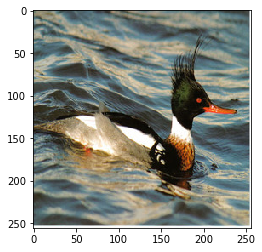

In [30]:
imshow(orient(X_train[2]))

In [62]:
patches = coates_ng_help.grab_patches(X_train, tot_patches=2e7, patch_size=32, seed=0)
patches_flat = patches.reshape(patches.shape[0], -1)

In [71]:
patches_sharded = sharded_matrix.ShardedMatrix("imagenet_patches_raw_uint8", bucket="vaishaalpywrenlinalg", reshard=True, data=patches_flat, shard_size_0=65536*4, n_jobs=32)

Sharding matrix..... of shape (20000000, 3072)
1048576 1310720 0 3072
1572864 052428818350087864322621441310720     262144 0104857652428815728642359296 786432     4456448498073626214403932160209715218350080 30720002621440      5767168471859255050247340032681574452428807864320367001670778886291456 0
    471859252428802883584419430423592962097152          760217660293124194304812646465536002883584314572834078723072  3072307230720      6029312498073657671687602176707788855050248126464393216073400326553600       
30723670016


 000000          7864320629145644564488388608681574431457283407872 
   3072      0000000000    000000
307230723072307230723072          00       





3072307230723072307230723072307230723072 30723072307230723072307230723072

















8388608 8650752 0 3072
8912896 9175040 0 91750403072
 9437184 0 3072
8650752 8912896 0 3072
9437184 9699328 0 3072
99614729699328  10223616 9961472 00  30723072

10223616 10485760 0 3072
10485760 10747904 0 3072
10747904 11010048

In [74]:
patches_block = patches_sharded.get_block(0,0)

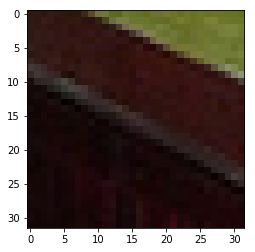

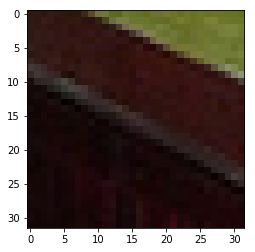

In [91]:
imshow(orient(patches[2392]))

In [93]:
X_train_lift = sharded_matrix.ShardedMatrix("coatesng_1024_19_4_24_12_4.45_0(imagenet_train_raw_uint8)", bucket="picturewebhyperband") 

In [ ]:
X_train_lift.get_block(0,0)

In [46]:
'''(59, 0), (146, 0), (64, 0), (167, 0), (85, 0), (172, 0), (259, 0), (90, 0), (177, 0), (264, 0), (111, 0), (198, 0), (285, 0), (116, 0), (203, 0), (290, 0), (121, 0), (208, 0), 
 (311, 0), (229, 0), (234, 0), (255, 0), (4, 0), (9, 0), (30, 0), (35, 0), (40, 0), (143, 0), 
 (61, 0), (148, 0), (66, 0), (153, 0), (87, 0), (174, 0), (261, 0), (92, 0), (179, 0), 
 (266,0), (97, 0), (184, 0), (287, 0), (118, 0), (205, 0), (292, 0), (123, 0), (210, 0), (297, 0), 
 (231, 0), (236, 0), (241, 0), (6, 0), (11, 0), (16, 0), (37, 0), (42, 0), (129, 0), 
 (63,0), (150, 0), (68, 0), (155, 0), (73, 0), (160, 0), (263, 0), (94, 0), (181, 0), (268, 0), 
 (99, 0), (186, 0), (273, 0), (104, 0), (207, 0), (294, 0), (125, 0), (212, 0), (299, 0),
(217, 0), (304, 0), (238, 0), (243, 0), (248, 0), (13, 0), (18, 0), (39, 0), (44, 0), (131, 0), (49, 0), (136, 0), (70, 0), (157, 0), (75, 0), (162, 0), (80, 0), (183, 0), (270, 0),
 (101, 0), (188, 0), (275, 0), (106, 0), (193, 0), (280, 0), (127, 0), (214, 0), (301, 0), (219, 0), (306, 0), (224, 0), (245, 0), (250, 0), (15, 0), (20, 0), (25, 0), (46, 0), (133
, 0), (51, 0), (138, 0), (56, 0), (159, 0), (77, 0), (164, 0), (82, 0), (169, 0), (256, 0), (103, 0), (190, 0), (277, 0), (108, 0), (195, 0), (282, 0), (113, 0), (200, 0), (303, 0),
 (221, 0), (308, 0), (226, 0), (247, 0), (252, 0), (1, 0), (22, 0), (27, 0), (32, 0), (135, 0), (53, 0), (140, 0), (58, 0), (145, 0), (79, 0), (166, 0), (84, 0), (171, 0), (258, 0),
 (89, 0), (176, 0), (279, 0), (110, 0), (197, 0), (284, 0), (115, 0), (202, 0), (289, 0), (120, 0), (223, 0), (310, 0), (228, 0), (233, 0), (254, 0), (3, 0), (8, 0), (29, 0), (34, 0
), (55, 0), (142, 0), (60, 0), (147, 0), (65, 0), (152, 0), (86, 0), (173, 0), (260, 0), (91, 0), (178, 0), (265, 0), (96, 0), (199, 0), (286, 0), (117, 0), (204, 0), (291, 0), (122
, 0), (209, 0), (296, 0), (230, 0), (235, 0), (240, 0), (5, 0), (10, 0), (31, 0), (36, 0), (41, 0), (128, 0), (62, 0), (149, 0), (67, 0), (154, 0), (72, 0), (175, 0), (262, 0), (93,
 0), (180, 0), (267, 0), (98, 0), (185, 0), (272, 0), (119, 0), (206, 0), (293, 0), (124, 0), (211, 0), (298, 0), (216, 0), (237, 0), (242, 0), (7, 0), (12, 0), (17, 0), (38, 0), (4
3, 0), (130, 0), (48, 0), (151, 0), (69, 0), (156, 0), (74, 0), (161, 0), (95, 0), (182, 0), (269, 0), (100, 0), (187, 0), (274, 0), (105, 0), (192, 0), (295, 0), (126, 0), (213, 0)
, (300, 0), (218, 0), (305, 0), (239, 0), (244, 0), (249, 0), (14, 0), (19, 0), (24, 0), (45, 0), (132, 0), (50, 0), (137, 0), (71, 0), (158, 0), (76, 0), (163, 0), (81, 0), (168, 0
), (271, 0), (102, 0), (189, 0), (276, 0), (107, 0), (194, 0), (281, 0), (112, 0), (215, 0), (302, 0), (220, 0), (307, 0), (225, 0), (312, 0), (246, 0), (251, 0), (0, 0), (21, 0), (
26, 0), (47, 0), (134, 0), (52, 0), (139, 0), (57, 0), (144, 0), (78, 0), (165, 0), (83, 0), (170, 0), (257, 0), (88, 0), (191, 0), (278, 0), (109, 0), (196, 0), (283, 0), (114, 0),
 (201, 0), (288, 0), (222, 0), (309, 0), (227, 0), (232, 0), (253, 0), (2, 0), (23, 0), (28, 0), (33, 0), (54, 0), (141, 0)'''.count('(')

313

In [55]:
from boto.s3 import deletemarker
from boto.s3.connection import S3Connection
from boto.s3.key import Key
conn = boto3.client('s3')
bucket = conn.get_bucket("imagenet-raw")
for version in bucket.list_versions():
    if isinstance(version, deletemarker.DeleteMarker) and version.is_latest:
        bucket.delete_key(version.name, version_id=version.version_id)

AttributeError: 'S3' object has no attribute 'get_bucket'